In [1]:
import geopandas as gpd
import pandas as pd
from shapely.ops import unary_union
import matplotlib.pyplot as plt
import uuid 
pd.set_option('display.max_columns',None)

# Step 1: Load the data
gdf = gpd.read_file(r"C:\Users\adam.PROPDO\Downloads\SC_Malha_Preliminar_2022 (2)\SC_Malha_Preliminar_2022.shp")
gdf = gdf.to_crs('EPSG:4326')
gdf.columns=gdf.columns.str.lower()
gdf=gdf[['cd_setor','area_km2','nm_mun','v0001','geometry']]
gdf=gdf[gdf['nm_mun']=='São José']

In [2]:
gdf.head()

,cd_setor,area_km2,nm_mun,v0001,geometry
13254,421660205000001P,0.208012,São José,435,"POLYGON ((-48.61279 -27.58832, -48.61289 -27.5..."
13255,421660205000002P,0.013936,São José,554,"POLYGON ((-48.61599 -27.59334, -48.61663 -27.5..."
13256,421660205000003P,0.020509,São José,580,"POLYGON ((-48.61289 -27.58869, -48.61226 -27.5..."
13257,421660205000005P,0.052682,São José,623,"POLYGON ((-48.61042 -27.59112, -48.61084 -27.5..."
13258,421660205000007P,0.010878,São José,542,"POLYGON ((-48.61212 -27.59312, -48.61192 -27.5..."


In [3]:
len(gdf)

375

<Axes: >

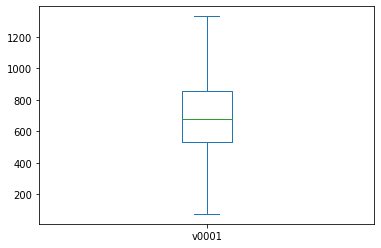

In [4]:
gdf['v0001'].plot(kind='box',showfliers=False)

In [5]:
# Step 2: Filter out small polygons
# Identify polygons with area below 
small_polygons = gdf[gdf['v0001'] < 800]

# Step 3: Spatial join to find neighboring polygons
# Use spatial join to find adjacent polygons for each small polygon
neighbors = gpd.sjoin(small_polygons, gdf, how="left", predicate="touches")

# Check column names to confirm indices
print(neighbors.columns)

Index(['cd_setor_left', 'area_km2_left', 'nm_mun_left', 'v0001_left',
       'geometry', 'index_right', 'cd_setor_right', 'area_km2_right',
       'nm_mun_right', 'v0001_right'],
      dtype='object')


In [6]:
neighbors.head()

,cd_setor_left,area_km2_left,nm_mun_left,v0001_left,geometry,index_right,cd_setor_right,area_km2_right,nm_mun_right,v0001_right
13254,421660205000001P,0.208012,São José,435,"POLYGON ((-48.61279 -27.58832, -48.61289 -27.5...",13530,421660213000057P,0.273710,São José,826
13254,421660205000001P,0.208012,São José,435,"POLYGON ((-48.61279 -27.58832, -48.61289 -27.5...",13295,421660205000049P,0.314532,São José,692
13254,421660205000001P,0.208012,São José,435,"POLYGON ((-48.61279 -27.58832, -48.61289 -27.5...",13265,421660205000014P,0.049892,São José,363
13254,421660205000001P,0.208012,São José,435,"POLYGON ((-48.61279 -27.58832, -48.61289 -27.5...",13261,421660205000010P,0.026319,São José,529
13254,421660205000001P,0.208012,São José,435,"POLYGON ((-48.61279 -27.58832, -48.61289 -27.5...",13262,421660205000011P,0.013563,São José,539


In [7]:
import geopandas as gpd
from shapely.ops import unary_union
import pandas as pd

# Step 4: Group and merge polygons until neighborhoods reach a population threshold
def merge_polygons_by_population(gdf, population_threshold=10000):  # Threshold in population
    # Initialize merged GeoDataFrame with same CRS as gdf and add a Bairro column
    merged_gdf = gpd.GeoDataFrame(columns=gdf.columns.to_list() + ['bairro'], crs=gdf.crs)
    processed_ids = set()  # Track processed polygon identifiers
    bairro_id = 1  # Start numbering neighborhoods from 1

    for idx, row in gdf.iterrows():
        if row['v0001'] >= population_threshold or idx in processed_ids:
            continue  # Skip if already processed or already meets threshold

        # Collect adjacent polygons to merge
        neighbors_to_merge = [row]  # Start with the current polygon
        total_population = row['v0001']
        
        # Keep merging neighbors until the population threshold is met
        while total_population < population_threshold:
            # Find neighbors of all current polygons in the merge group
            current_neighbors = neighbors[
                neighbors['cd_setor_left'].isin([r['cd_setor'] for r in neighbors_to_merge]) & 
                ~neighbors['index_right'].isin(processed_ids)
            ]
            if current_neighbors.empty:
                break  # No more neighbors to merge

            # Retrieve the identifier of the next neighbor
            next_neighbor_id = current_neighbors['index_right'].iloc[0]
            next_neighbor = gdf.loc[next_neighbor_id]  # Retrieve by actual identifier

            neighbors_to_merge.append(next_neighbor)
            total_population += next_neighbor['v0001']
            processed_ids.add(next_neighbor_id)

        # Merge all collected polygons
        merged_geometry = unary_union([poly.geometry for poly in neighbors_to_merge])
        merged_row = row.copy()
        merged_row['v0001'] = total_population
        merged_row.geometry = merged_geometry
       
        # Generate a UUID and assign it to the bairro column
        merged_row['bairro'] = str(uuid.uuid4())

        # Convert merged row to GeoDataFrame and set CRS
        merged_row_gdf = gpd.GeoDataFrame([merged_row], crs=gdf.crs)
        # Append to the result GeoDataFrame using pd.concat()
        merged_gdf = pd.concat([merged_gdf, merged_row_gdf], ignore_index=True)

        # Increment the neighborhood identifier for the next bairro
        bairro_id += 1

    # Append polygons that already meet the population threshold
    large_polygons = gdf[gdf['v0001'] >= population_threshold].copy()
    large_polygons['bairro'] = [str(uuid.uuid4()) for _ in range(len(large_polygons))]
    merged_gdf = pd.concat([merged_gdf, large_polygons], ignore_index=True)

    return merged_gdf


In [8]:
# Step 5: Apply the merging function and view results
neighborhoods_gdf = merge_polygons_by_population(gdf, population_threshold=10000)
neighborhoods_gdf = neighborhoods_gdf.to_crs('EPSG:4326')
neighborhoods_gdf=neighborhoods_gdf.drop(columns=['cd_setor'])
neighborhoods_gdf.head()

,area_km2,nm_mun,v0001,geometry,bairro
0,0.208012,São José,10037,"POLYGON ((-48.61758 -27.59429, -48.61780 -27.5...",3fac64e1-a387-47f8-9931-d37cc8ef2167
1,0.015501,São José,10636,"POLYGON ((-48.61956 -27.60267, -48.62009 -27.6...",776b220b-4ed5-4282-a372-65a1c82a733a
2,0.184309,São José,10225,"POLYGON ((-48.60182 -27.65902, -48.60198 -27.6...",eb5f06fa-79e0-4a30-8987-5173d9ae2f78
3,0.010013,São José,1625,"POLYGON ((-48.61113 -27.59842, -48.61100 -27.5...",a820ab21-10a2-4e7a-b53b-1b22d9d3c48a
4,0.033723,São José,2751,"POLYGON ((-48.60803 -27.59195, -48.60823 -27.5...",e028cc50-3100-46d3-a1da-694782ad4952


In [9]:
len(neighborhoods_gdf)

86

In [10]:
neighborhoods_gdf=neighborhoods_gdf.rename(columns={'bairro':'bairro_id'})
neighborhoods_gdf=neighborhoods_gdf[['bairro_id','area_km2','nm_mun','v0001','geometry']]

In [11]:
neighborhoods_gdf = neighborhoods_gdf.to_crs('EPSG:4326')

In [14]:
# Save or plot the result
neighborhoods_gdf.to_file(r"P:\Data (adam)\Agente Imovel Team Support\New Data\Neighbourhoods for failed cities\Neighborhood New Files\Sao Jose, Santa Caterina\neighborhood Sao Jose.shp")

<Figure size 1440x720 with 0 Axes>

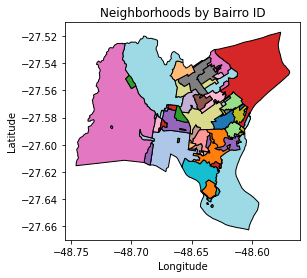

In [23]:
plt.figure(figsize=(20, 10)) 
neighborhoods_gdf.plot(column='bairro_id', cmap='tab20', edgecolor='black', legend=False)
plt.title("Neighborhoods by Bairro ID")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.savefig(r"P:\Data (adam)\Agente Imovel Team Support\New Data\Neighbourhoods for failed cities\Neighborhood New Files\Sao Jose, Santa Caterina\neighborhoods_map.png", dpi=300, bbox_inches='tight')
plt.show()